# **SL VI Mini Project**

## H-1B Visa Analysis
![image](https://d2v9ipibika81v.cloudfront.net/uploads/sites/114/2016/03/visa-759.jpg)

---
---

###### 33341 Krishiv Mewani
###### 33344 Harshad Manglani
###### 33351 Tanay Patankar
###### 33354 Satyajeet Patil

# Loading Datasets and installing and importing necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir datasets
!unzip gdrive/MyDrive/Datasets/h1b_dataset.zip -d datasets

mkdir: cannot create directory ‘datasets’: File exists
Archive:  gdrive/MyDrive/Datasets/h1b_dataset.zip
  inflating: datasets/h1b16.csv      
  inflating: datasets/h1b17.csv      
  inflating: datasets/h1b18.csv      


In [ ]:
%%capture

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as py
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score


!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
cols = ['CASE_STATUS','EMPLOYMENT_START_DATE','EMPLOYER_NAME',
        'EMPLOYER_STATE','JOB_TITLE','SOC_NAME','PREVAILING_WAGE','PW_UNIT_OF_PAY']

# Importing the Datasets
df18 = pd.read_csv('datasets/h1b18.csv', usecols = cols)
df17 = pd.read_csv('datasets/h1b17.csv', usecols = cols)
df16 = pd.read_csv('datasets/h1b16.csv')

In [ ]:
df16.head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [ ]:
df17.head()

,CASE_STATUS,EMPLOYMENT_START_DATE,EMPLOYER_NAME,EMPLOYER_STATE,JOB_TITLE,SOC_NAME,PREVAILING_WAGE,PW_UNIT_OF_PAY
0,CERTIFIED-WITHDRAWN,2016-08-10,DISCOVER PRODUCTS INC.,IL,ASSOCIATE DATA INTEGRATION,COMPUTER SYSTEMS ANALYSTS,59197.0,Year
1,CERTIFIED-WITHDRAWN,2016-08-16,DFS SERVICES LLC,IL,SENIOR ASSOCIATE,OPERATIONS RESEARCH ANALYSTS,49800.0,Year
2,CERTIFIED-WITHDRAWN,2016-09-09,EASTBANC TECHNOLOGIES LLC,DC,.NET SOFTWARE PROGRAMMER,COMPUTER PROGRAMMERS,76502.0,Year
3,WITHDRAWN,2017-01-26,INFO SERVICES LLC,MI,PROJECT MANAGER,"COMPUTER OCCUPATIONS, ALL OTHER",90376.0,Year
4,CERTIFIED-WITHDRAWN,2015-03-01,BB&T CORPORATION,NC,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,CREDIT ANALYSTS,116605.0,Year


In [ ]:
df18.head()

,CASE_STATUS,EMPLOYMENT_START_DATE,EMPLOYER_NAME,EMPLOYER_STATE,JOB_TITLE,SOC_NAME,PREVAILING_WAGE,PW_UNIT_OF_PAY
0,CERTIFIED,7/28/18,MICROSOFT CORPORATION,WA,SOFTWARE ENGINEER,"SOFTWARE DEVELOPERS, APPLICATIONS","112,549.00",Year
1,CERTIFIED,11/6/17,ERNST & YOUNG U.S. LLP,NJ,TAX SENIOR,ACCOUNTANTS AND AUDITORS,"79,976.00",Year
2,CERTIFIED,9/10/18,LOGIXHUB LLC,TX,DATABASE ADMINISTRATOR,DATABASE ADMINISTRATORS,"77,792.00",Year
3,CERTIFIED,9/10/18,"HEXAWARE TECHNOLOGIES, INC.",NJ,SOFTWARE ENGINEER,"SOFTWARE DEVELOPERS, APPLICATIONS","84,406.00",Year
4,CERTIFIED,9/7/18,"ECLOUD LABS,INC.",NJ,MICROSOFT DYNAMICS CRM APPLICATION DEVELOPER,"SOFTWARE DEVELOPERS, APPLICATIONS","87,714.00",Year


# Data Transformation

#### Selecting the necessary columns

In [ ]:
# Removing columns that are not necessary from data of df18 and df17
df17 = df17[['CASE_STATUS','EMPLOYMENT_START_DATE','EMPLOYER_NAME',
        'EMPLOYER_STATE','JOB_TITLE','SOC_NAME','PREVAILING_WAGE','PW_UNIT_OF_PAY']]

df18 = df18[['CASE_STATUS','EMPLOYMENT_START_DATE','EMPLOYER_NAME',
        'EMPLOYER_STATE','JOB_TITLE','SOC_NAME','PREVAILING_WAGE','PW_UNIT_OF_PAY']]

#### Standardising the format of the date

In [ ]:
# Changing the EMPLOYMENT_START_DATE into a year to comply with 2016 data
df18['EMPLOYMENT_START_DATE'] = pd.to_datetime(df18['EMPLOYMENT_START_DATE'], format = '%m/%d/%y')
df18['EMPLOYMENT_START_DATE'] = df18['EMPLOYMENT_START_DATE'].apply(lambda x: x.year)

df17['EMPLOYMENT_START_DATE'] = pd.to_datetime(df17['EMPLOYMENT_START_DATE'], format = '%Y-%m-%d')
df17['EMPLOYMENT_START_DATE'] = df17['EMPLOYMENT_START_DATE'].apply(lambda x: x.year)

In [ ]:
# Only take years 2017 from df17 and years 2018 from df18
df17 = df17.loc[df17['EMPLOYMENT_START_DATE'] == 2017, :]
df18 = df18.loc[df18['EMPLOYMENT_START_DATE'] == 2018, :]

#### Checking Missing Entries

In [ ]:
print('Number of entries:', df16.shape[0])
print('Number of missing data in each column:')
print(df16.isnull().sum())

Number of entries: 3002458
Number of missing data in each column:
Unnamed: 0                 0
CASE_STATUS               13
EMPLOYER_NAME             59
SOC_NAME               17734
JOB_TITLE                 43
FULL_TIME_POSITION        15
PREVAILING_WAGE           85
YEAR                      13
WORKSITE                   0
lon                   107242
lat                   107242
dtype: int64


In [ ]:
print('Number of entries:', df17.shape[0])
print('Number of missing data in each column:')
print(df17.isnull().sum())

Number of entries: 530371
Number of missing data in each column:
CASE_STATUS               0
EMPLOYMENT_START_DATE     0
EMPLOYER_NAME            51
EMPLOYER_STATE           13
JOB_TITLE                 3
SOC_NAME                  1
PREVAILING_WAGE           1
PW_UNIT_OF_PAY           39
dtype: int64


In [ ]:
print('Number of entries:', df18.shape[0])
print('Number of missing data in each column:')
print(df18.isnull().sum())

Number of entries: 556038
Number of missing data in each column:
CASE_STATUS               0
EMPLOYMENT_START_DATE     0
EMPLOYER_NAME             8
EMPLOYER_STATE           66
JOB_TITLE                 1
SOC_NAME                  7
PREVAILING_WAGE           3
PW_UNIT_OF_PAY           45
dtype: int64


In [ ]:
# Dropping the rows with nan values
df16 = df16.drop(['lon','lat'], axis=1)
df16 = df16.dropna()
df17 = df17.dropna()
df18 = df18.dropna()

Dataset is quite organized with nearly no missing relevent values in 2 of the files

#### Standardising the different formats of wages

In [ ]:
df17.PW_UNIT_OF_PAY.unique()

array(['Year', 'Hour', 'Month', 'Week', 'Bi-Weekly'], dtype=object)

In [ ]:
# Change PREVAILING WAGE into only yearly wages (Split into Year, Week, Month, Hourly, Bi-weekly)
df18['PREVAILING_WAGE'] = df18['PREVAILING_WAGE'].apply(lambda x: str(x).replace(',',''))
df18.loc[df18.PREVAILING_WAGE == 0, 'PREVAILING_WAGE'] = np.nan
df18.loc[df18.PW_UNIT_OF_PAY == 'Hour', 'PREVAILING_WAGE'] = df18.loc[df18.PW_UNIT_OF_PAY == 'Hour', 'PREVAILING_WAGE'].apply(lambda x:float(x)*1638)
df18.loc[df18.PW_UNIT_OF_PAY == 'Week', 'PREVAILING_WAGE'] = df18.loc[df18.PW_UNIT_OF_PAY == 'Week', 'PREVAILING_WAGE'].apply(lambda x:float(x)*52)
df18.loc[df18.PW_UNIT_OF_PAY == 'Bi-Weekly', 'PREVAILING_WAGE'] = df18.loc[df18.PW_UNIT_OF_PAY == 'Bi-Weekly', 'PREVAILING_WAGE'].apply(lambda x:float(x)*26)
df18.loc[df18.PW_UNIT_OF_PAY == 'Month', 'PREVAILING_WAGE'] = df18.loc[df18.PW_UNIT_OF_PAY == 'Month', 'PREVAILING_WAGE'].apply(lambda x:float(x)*12)

df17['PREVAILING_WAGE'] = df17['PREVAILING_WAGE'].apply(lambda x: str(x).replace(',',''))
df17.loc[df17.PREVAILING_WAGE == 0, 'PREVAILING_WAGE'] = np.nan
df17.loc[df17.PW_UNIT_OF_PAY == 'Hour', 'PREVAILING_WAGE'] = df17.loc[df17.PW_UNIT_OF_PAY == 'Hour', 'PREVAILING_WAGE'].apply(lambda x:float(x)*1638)
df17.loc[df17.PW_UNIT_OF_PAY == 'Week', 'PREVAILING_WAGE'] = df17.loc[df17.PW_UNIT_OF_PAY == 'Week', 'PREVAILING_WAGE'].apply(lambda x:float(x)*52)
df17.loc[df17.PW_UNIT_OF_PAY == 'Bi-Weekly', 'PREVAILING_WAGE'] = df17.loc[df17.PW_UNIT_OF_PAY == 'Bi-Weekly', 'PREVAILING_WAGE'].apply(lambda x:float(x)*26)
df17.loc[df17.PW_UNIT_OF_PAY == 'Month', 'PREVAILING_WAGE'] = df17.loc[df17.PW_UNIT_OF_PAY == 'Month', 'PREVAILING_WAGE'].apply(lambda x:float(x)*12)

In [ ]:
# Remove PW_UNIT_OF_PAY
df17 = df17[['CASE_STATUS','EMPLOYMENT_START_DATE','EMPLOYER_NAME',
        'EMPLOYER_STATE','JOB_TITLE','SOC_NAME','PREVAILING_WAGE']]

df18 = df18[['CASE_STATUS','EMPLOYMENT_START_DATE','EMPLOYER_NAME',
        'EMPLOYER_STATE','JOB_TITLE','SOC_NAME','PREVAILING_WAGE']]

#### Converting locations into state codes

In [ ]:
# Dictionary of all States and Shortened State
states = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado",
          "CT":"Connecticut","DC":"District Of Columbia","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho",
          "IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana",
          "ME":"Maine","MD":"Maryland","MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi",
          "MO":"Missouri","MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey",
          "NM":"New Mexico","NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma",
          "OR":"Oregon","PA":"Pennsylvania","PR":"Puerto Rico","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota",
          "TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont","VA":"Virginia","WA":"Washington",
          "WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}
states = dict((v.upper(), k.upper()) for k, v in states.items())

# Remove the city from the WORKSITE
df16['WORKSITE'] = df16['WORKSITE'].apply(lambda x: x.split(',')[1].strip())
# Replace Worksite with shortened States
df16['WORKSITE'].replace(states, inplace = True)
# Replace WORKSITE with EMPLOYER_STATE
df16.rename(columns={'YEAR':'EMPLOYMENT_START_DATE','WORKSITE':'EMPLOYER_STATE'}, inplace=True)


# Removing unnecessary columns of df16
df16 = df16[['CASE_STATUS','EMPLOYMENT_START_DATE','EMPLOYER_NAME',
        'EMPLOYER_STATE','JOB_TITLE','SOC_NAME','PREVAILING_WAGE']]

#### Integrating the different datasets

In [ ]:
df = pd.concat([df16,df17,df18])
df = df.reset_index(drop = True)
df.head()

,CASE_STATUS,EMPLOYMENT_START_DATE,EMPLOYER_NAME,EMPLOYER_STATE,JOB_TITLE,SOC_NAME,PREVAILING_WAGE
0,CERTIFIED-WITHDRAWN,2016.0,UNIVERSITY OF MICHIGAN,MI,POSTDOCTORAL RESEARCH FELLOW,BIOCHEMISTS AND BIOPHYSICISTS,36067
1,CERTIFIED-WITHDRAWN,2016.0,"GOODMAN NETWORKS, INC.",TX,CHIEF OPERATING OFFICER,CHIEF EXECUTIVES,242674
2,CERTIFIED-WITHDRAWN,2016.0,"PORTS AMERICA GROUP, INC.",NJ,CHIEF PROCESS OFFICER,CHIEF EXECUTIVES,193066
3,CERTIFIED-WITHDRAWN,2016.0,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CO,"REGIONAL PRESIDEN, AMERICAS",CHIEF EXECUTIVES,220314
4,WITHDRAWN,2016.0,PEABODY INVESTMENTS CORP.,MO,PRESIDENT MONGOLIA AND INDIA,CHIEF EXECUTIVES,157518


#### Final error correction

In [ ]:
# Cleaning the SOC_NAME
df['SOC_NAME'] = df['SOC_NAME'].apply(lambda x: str(x).upper())
df['SOC_NAME'] = df['SOC_NAME'].apply(lambda x:str(x).replace('COMPUTER SYSTEMS ANALYSTS','COMPUTER SYSTEMS ANALYST'))

# Changing Wage to float
df['PREVAILING_WAGE'] = df['PREVAILING_WAGE'].astype(str).astype(float)

# Visualisations

#### Applicants Per Year

In [ ]:
# Looking at the number of applications per year
year_applicants = df['EMPLOYMENT_START_DATE'].value_counts()
print(year_applicants)

2016.0    647803
2015.0    618727
2018.0    556038
2017.0    530371
2014.0    519427
2013.0    442114
2012.0    415607
2011.0    358767
Name: EMPLOYMENT_START_DATE, dtype: int64


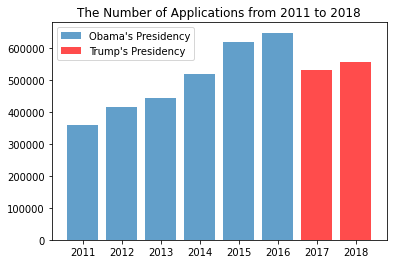

In [ ]:
# Visualising the number of applications per year

year_applicants = year_applicants.sort_index()

obama = pd.Series(year_applicants.values[0:6], index = year_applicants.index[0:6])
trump = pd.Series(year_applicants.values[6:], index = year_applicants.index[6:])

fig, ax = plt.subplots()
plt.bar(obama.index, obama.values, align = 'center', alpha = 0.7,  linewidth=0)
plt.bar(trump.index, trump.values, align = 'center', alpha = 0.7,  linewidth=0, color = '#FF0000')
plt.legend(['Obama\'s Presidency','Trump\'s Presidency'],loc=2)
plt.title('The Number of Applications from 2011 to 2018')

plt.show()

From the series above, we can see that there are about 500,000 applicants every year. We can also see that there has been a decrease in the number of applications in 2017 and 2018 (Trump's Presidency) The figure below highlights the fall in the number of applicants in Trump's Presidency

#### Job Location

In [ ]:
# Organizing by state
df_heatmap = df.groupby('EMPLOYER_STATE')['CASE_STATUS'].count()

In [ ]:
scl = [
    [0.0, 'rgb(242,240,247)'],
    [0.2, 'rgb(218,218,235)'],
    [0.4, 'rgb(188,189,220)'],
    [0.6, 'rgb(158,154,200)'],
    [0.8, 'rgb(117,107,177)'],
    [1.0, 'rgb(84,39,143)']
]

fig = go.Figure(
    data=go.Choropleth(
      locations=df_heatmap.index, # Spatial coordinates
      z = df_heatmap.values.astype(float), # Data to be color-coded
      locationmode = 'USA-states', # set of locations match entries in `locations`
      marker = go.choropleth.Marker(
          line = go.choropleth.marker.Line(
              color = 'rgb(255,255,255)',
              width = 2
          )),
      colorscale = scl,
      autocolorscale = False,
      colorbar = go.choropleth.ColorBar(
          title = "")
    ),
    layout = go.Layout(
      title = go.layout.Title(
          text = 'H1B Visa Applicants'
      ),
      geo = go.layout.Geo(
          scope = 'usa',
          projection = go.layout.geo.Projection(type = 'albers usa'),
          showlakes = True,
          lakecolor = 'rgb(255, 255, 255)'),
    )
  )

# fig.show(renderer="png")
fig.show(renderer="colab")


This choropleth map highlights the location of applicants. From the figure, we can see that the majority of the H-1B visa applicants are applying from California, New York, and Texas.

#### Acceptance Status


In [ ]:
# Comparing the number of applications that are accepted or denied (Ignore withdrawn)
accept_arr = df['CASE_STATUS'].value_counts()
print(accept_arr)
accept_val = list(accept_arr)[0:4]
accept_label = list(accept_arr.index)[0:4]

# Out of all the applications we can see that only a small percentage are denied (Exactly 2.67%)
denied = (accept_arr['DENIED'] / df.shape[0]).round(4)
print(str(denied*100) + '%')

CERTIFIED                                             3615378
CERTIFIED-WITHDRAWN                                    241703
WITHDRAWN                                              122466
DENIED                                                 109289
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64
2.67%


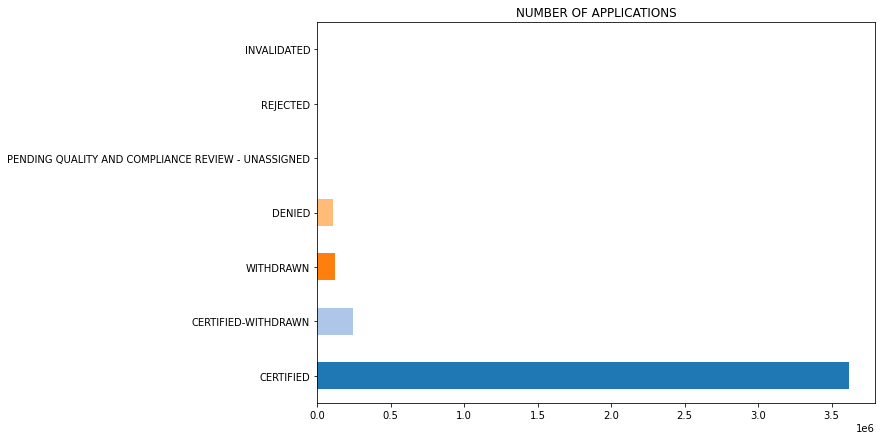

In [ ]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.figure(figsize=(10,7))
df.CASE_STATUS.value_counts().plot(kind='barh',  color=tableau20)
df.sort_values('CASE_STATUS')
plt.title("NUMBER OF APPLICATIONS")
plt.show()

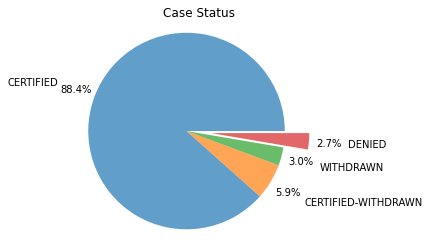

In [ ]:
# Pie chart of accepted and denied applications
fig, ax = plt.subplots()
ax.pie(accept_val, explode = (0,0,0,0.25), labels = accept_label, autopct = '%1.1f%%',
       pctdistance=1.2, labeldistance=1.4, wedgeprops={'alpha':0.7})
ax.axis('equal')
plt.title('Case Status')
plt.show()

#### Applicant Company Analysis

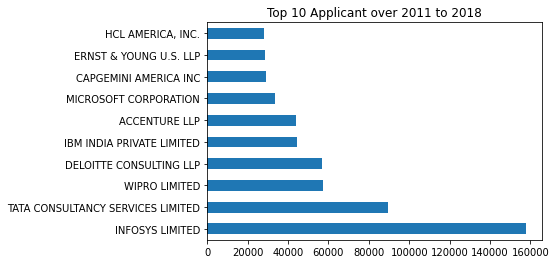

In [ ]:
fig, ax = plt.subplots()
ax = df['EMPLOYER_NAME'].groupby([df['EMPLOYER_NAME']]).count().sort_values(ascending=False).head(10).plot(kind='barh', title="Top 10 Applicant over 2011 to 2018")
ax.set_ylabel("")
plt.show()

In [ ]:
topEmp = list(df['EMPLOYER_NAME'][df['EMPLOYMENT_START_DATE'] >= 2015].groupby(df['EMPLOYER_NAME']).count().sort_values(ascending=False).head(10).index)
byEmpYear = df[['PREVAILING_WAGE', 'EMPLOYER_NAME', 'EMPLOYMENT_START_DATE']][df['EMPLOYER_NAME'].isin(topEmp)]
byEmpYear = byEmpYear.groupby([df['EMPLOYER_NAME'],df['EMPLOYMENT_START_DATE']])

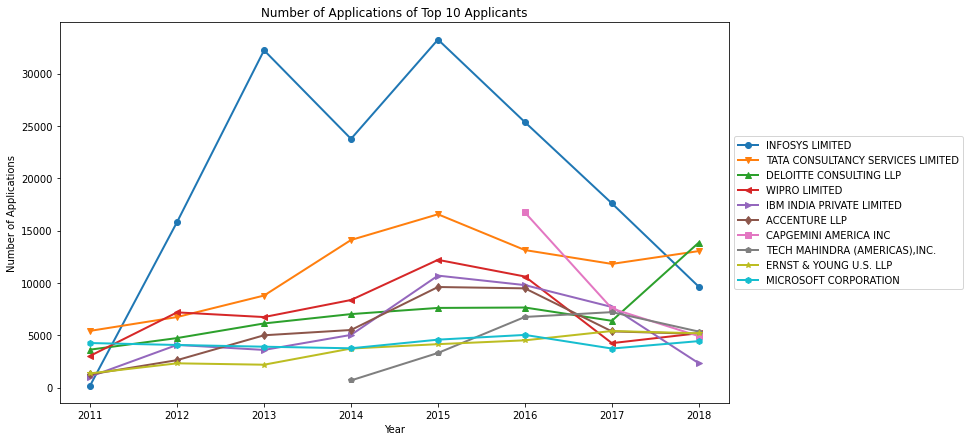

In [ ]:
markers=['o','v','^','<','>','d','s','p','*','h','x','D','o','v','^','<','>','d','s','p','*','h','x','D']
fig = plt.figure(figsize=(12,7))
for company in topEmp:
    tmp = byEmpYear.count().loc[company]
    plt.plot(tmp.index.values, tmp["PREVAILING_WAGE"].values, label=company, linewidth=2,marker=markers[topEmp.index(company)])
plt.xlabel("Year")
plt.ylabel("Number of Applications")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Applications of Top 10 Applicants')
plt.show()

- INFOSIS shows a very rapid development, especially during period from 2011 to 2013, where it came from about zero to 32k applications and a rapid decline 2016 onwards.
- TATA also shows a significant development.
- Most of the top applicants are from India.

#### Jobs Analysis

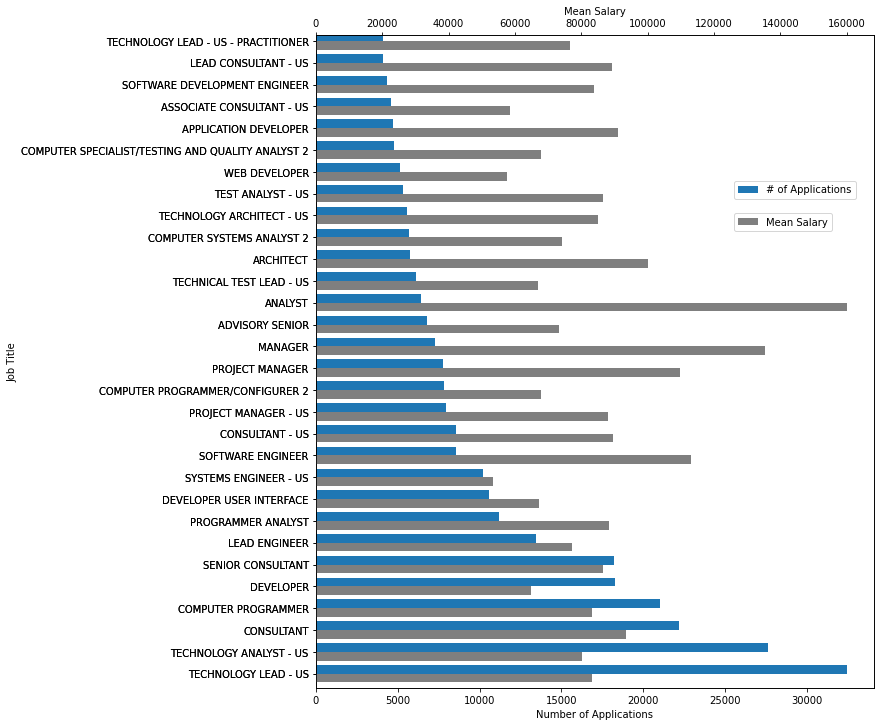

In [ ]:
PopJobs = df[['JOB_TITLE', 'EMPLOYER_NAME', 'PREVAILING_WAGE']][df['EMPLOYER_NAME'].isin(topEmp)].groupby(['JOB_TITLE'])
topJobs = list(PopJobs.count().sort_values(by='EMPLOYER_NAME', ascending=False).head(30).index)
df_2 = PopJobs.count().loc[topJobs].assign(mean_wage=PopJobs.mean().loc[topJobs])
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
width = 0.35
df_2.EMPLOYER_NAME.plot(kind='barh', ax=ax1, color='C0', width=0.4, position=0, label='# of Applications')
df_2.mean_wage.plot(kind='barh', ax=ax2, color='C7', width=0.4, position=1, label='Mean Salary')
ax1.set_xlabel('Number of Applications')
ax1.set_ylabel('')
ax1.legend(loc=(0.75,0.75))
ax2.set_xlabel('Mean Salary')
ax2.set_ylabel('Job Title')
ax2.legend(loc=(0.75,0.70))
plt.show()

Top jobs from top 10 applications are mostly IT jobs. The most popular jobs are "Technology Lead" and "Technology Analyst" but their offering salary are not top, they are about middle. The positions offering the highest salary are "Analyst" and "Manager", which is absolutely understandable.

# Feature Engineering

### Finding and removing outliers

In [ ]:
df['PREVAILING_WAGE'].max()

6997606720.0

In [ ]:
df = df[df['PREVAILING_WAGE'] <= 500000]

#### Generalising the job categories

In [ ]:
%%capture
import sys

df['SOC_NAME1'] = 'others'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('computer','software')] = 'it'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('software|web')] = 'it'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('chief','management')] = 'manager'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('manager')] = 'manager'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('mechanical')] = 'mechanical'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('database')] = 'database'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('sales','market')] = 'scm'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('financial')] = 'finance'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('treasure')] = 'finance'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('public','fundraising')] = 'pr'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('education','law')] = 'administrative'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('auditors','compliance')] = 'audit'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('distribution','logistics')] = 'scm'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('recruiters','human')] = 'hr'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('agricultural','farm')] = 'agri'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('construction','architectural')] = 'estate'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('forencsic','health')] = 'medical'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('bio')] = 'medical'
df['SOC_NAME1'][df['SOC_NAME'].str.lower().str.contains('teachers')] = 'education'

In [ ]:
# Garbage Collection
gc.collect()

37097

In [ ]:
df['SOC_NAME1'].value_counts()

it                2522625
others             893429
manager            135794
education          112032
finance            101266
audit               74004
medical             70651
mechanical          65614
database            54328
scm                 29839
pr                  11354
administrative       7597
estate               4217
agri                 3039
hr                    219
Name: SOC_NAME1, dtype: int64

#### Encoding the Labels

In [ ]:
labelencoder_1 = LabelEncoder()

# df['CASE_STATUS_enc'] = labelencoder_1.fit_transform(df['CASE_STATUS'])
df['CASE_STATUS_enc'] = df['CASE_STATUS'].map({'CERTIFIED' : 1, 'CERTIFIED-WITHDRAWN' : 1, 'DENIED' : 0, 'WITHDRAWN' : 0,
                                           'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED' : 0, 'REJECTED' : 0, 'INVALIDATED' : 0})

labelencoder_2 = LabelEncoder()
df['EMPLOYER_STATE_enc'] = labelencoder_2.fit_transform(df['EMPLOYER_STATE'].astype(str))

labelencoder_3 = LabelEncoder()
df['SOC_NAME_enc'] = labelencoder_3.fit_transform(df['SOC_NAME1'].astype(str))
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,CASE_STATUS,EMPLOYMENT_START_DATE,EMPLOYER_NAME,EMPLOYER_STATE,JOB_TITLE,SOC_NAME,PREVAILING_WAGE,SOC_NAME1,CASE_STATUS_enc,EMPLOYER_STATE_enc,SOC_NAME_enc
0,CERTIFIED-WITHDRAWN,2016.0,UNIVERSITY OF MICHIGAN,MI,POSTDOCTORAL RESEARCH FELLOW,BIOCHEMISTS AND BIOPHYSICISTS,36067.0,medical,1,24,11
1,CERTIFIED-WITHDRAWN,2016.0,"GOODMAN NETWORKS, INC.",TX,CHIEF OPERATING OFFICER,CHIEF EXECUTIVES,242674.0,manager,1,48,9
2,CERTIFIED-WITHDRAWN,2016.0,"PORTS AMERICA GROUP, INC.",NJ,CHIEF PROCESS OFFICER,CHIEF EXECUTIVES,193066.0,manager,1,35,9
3,CERTIFIED-WITHDRAWN,2016.0,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CO,"REGIONAL PRESIDEN, AMERICAS",CHIEF EXECUTIVES,220314.0,manager,1,6,9
4,WITHDRAWN,2016.0,PEABODY INVESTMENTS CORP.,MO,PRESIDENT MONGOLIA AND INDIA,CHIEF EXECUTIVES,157518.4,manager,0,26,9
...,...,...,...,...,...,...,...,...,...,...,...
4088862,CERTIFIED,2018.0,VIRTUSA CORPORATION,MA,COMPUTER SYSTEMS ENGINEER 1,"COMPUTER OCCUPATIONS, ALL OTHER",67350.0,it,1,21,8
4088863,CERTIFIED,2018.0,CLASSROOM SUPPORT SERVICES LLC,MI,SOFTWARE ENGINEER,"SOFTWARE DEVELOPERS, APPLICATIONS",67246.0,it,1,24,8
4088864,CERTIFIED,2018.0,CROCKETT TECHNICAL LLC,TX,ASSOCIATE SOFTWARE ENGINEER,"SOFTWARE DEVELOPERS, APPLICATIONS",90646.0,it,1,48,8
4088865,CERTIFIED,2018.0,BRUNSWICK CORPORATION,IL,MANAGER GLOBAL SUPPLY CHAIN BUSINESS ANALYTICS,INDUSTRIAL ENGINEERS,68598.0,others,1,16,12


#### Removing unnecessary columns

In [ ]:
df.columns

Index(['CASE_STATUS', 'EMPLOYMENT_START_DATE', 'EMPLOYER_NAME',
       'EMPLOYER_STATE', 'JOB_TITLE', 'SOC_NAME', 'PREVAILING_WAGE',
       'SOC_NAME1', 'CASE_STATUS_enc', 'EMPLOYER_STATE_enc', 'SOC_NAME_enc'],
      dtype='object')

In [ ]:
df_final = df.drop(['CASE_STATUS','EMPLOYER_NAME', 'SOC_NAME','SOC_NAME1','JOB_TITLE','EMPLOYER_STATE'], axis = 1)
df_final

,EMPLOYMENT_START_DATE,PREVAILING_WAGE,CASE_STATUS_enc,EMPLOYER_STATE_enc,SOC_NAME_enc
0,2016.0,36067.0,1,24,11
1,2016.0,242674.0,1,48,9
2,2016.0,193066.0,1,35,9
3,2016.0,220314.0,1,6,9
4,2016.0,157518.4,0,26,9
...,...,...,...,...,...
4088862,2018.0,67350.0,1,21,8
4088863,2018.0,67246.0,1,24,8
4088864,2018.0,90646.0,1,48,8
4088865,2018.0,68598.0,1,16,12


#### Calculating the Coorelation

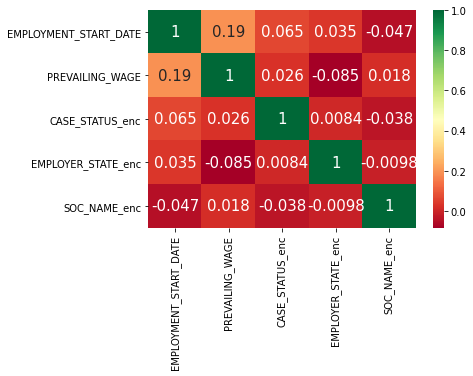

In [ ]:
sns.heatmap(df_final.corr(), annot=True, cmap="RdYlGn", annot_kws={"size":15})

Variables are weakly coorelated. So we will not remove any of the variables

### Dividing into dependant and independant variables

In [ ]:
x = df_final.drop(['CASE_STATUS_enc'], axis=1) # Independent variables
y = df_final['CASE_STATUS_enc'] # Dependent variables

# Model Building

## 1. Logistic Regression with Upscaled dataset

The dataset is highly imbalanced. To ensure that the minority class gets trained, we can upscale it to increase its accuracy. The downside of this is overfitting.

In [ ]:
# Separate majority and minority classes
df_majority = df_final[df_final.CASE_STATUS_enc==1]
df_minority = df_final[df_final.CASE_STATUS_enc==0]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=3856979,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.CASE_STATUS_enc.value_counts()

1    3856979
0    3856979
Name: CASE_STATUS_enc, dtype: int64

In [ ]:
x = df_upsampled.drop(['CASE_STATUS_enc'], axis=1) # Independent variables
y = df_upsampled['CASE_STATUS_enc'] # Dependent variables
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1234)

In [ ]:
lr_model = LogisticRegression()
lr_model_results = lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)

In [ ]:
# Is our model still predicting just one class?
print( np.unique( y_pred ) )

# How's our accuracy?
print( accuracy_score(y_test, y_pred) )

# AUC ROC Score
print(roc_auc_score(y_test, y_pred) )

[0 1]
0.5331222009620653
0.5331311594435356


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.58      0.56   1156888
           1       0.54      0.48      0.51   1157300

    accuracy                           0.53   2314188
   macro avg       0.53      0.53      0.53   2314188
weighted avg       0.53      0.53      0.53   2314188



With an upscaled dataset, the accuracy is quite low, at only 53%

## 2. Random Forest Classifier
Decision trees often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes.

In modern applied machine learning, tree ensembles (Random Forests, etc.) almost always outperform singular decision trees, so we'll use them directly.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 32)

In [ ]:
rf_model = RandomForestClassifier()
rf_model_results = rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

In [ ]:
# Is our model still predicting just one class?
print( np.unique( y_pred ) )

# How's our accuracy?
print( accuracy_score(y_test, y_pred) )

# AUC ROC Score
print(roc_auc_score(y_test, y_pred) )

print(classification_report(y_test, y_pred))

[0 1]
0.9351102909684509
0.52686778520459
              precision    recall  f1-score   support

           0       0.22      0.07      0.10     68277
           1       0.95      0.99      0.97   1157526

    accuracy                           0.94   1225803
   macro avg       0.59      0.53      0.54   1225803
weighted avg       0.91      0.94      0.92   1225803



Random forest chooses features randomly during the training process. Therefore, it does not depend highly on any specific set of features. Therefore, the random forest can generalize over the data in a better way

#### Ignore: Saving Models for reduced resource usage

In [ ]:
!mkdir gdrive/MyDrive/Datasets/models

In [ ]:
import pickle
model_name = 'rfc_model'
filename = 'gdrive/MyDrive/Datasets/models/' + model_name + '.sav'
# pickle.dump(model_name, open(filename, 'wb'))

# # load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(Y_test)
print(result)

In [ ]:
loaded_model

'rfc_model'